# Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

In [1]:
%%javascript

IPython.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : "run cell and keep focus", //This is optional
    handler : function (event) {
        IPython.notebook.execute_cell();
        IPython.notebook.edit_mode();
        return false;
    }}
);

<IPython.core.display.Javascript object>

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.transforms as transform

from torch.utils.serialization import load_lua
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd
# from models import build_ssd as build_ssd_v1 # uncomment for older pool6 model

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [3]:
net = build_ssd('test', 300, 20, controller_bias=False, controller_sigmoid=False,  # initialize SSD
                        insertBNLayers=False, residual_controllers=True,add_relu=False,
                    add_hint_interpreter = False)

In [4]:
net.state_dict().keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [25]:
a = torch.load('/home/amir/priming_weights/ssd300_0712_115000.pth2')
a.keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [4]:
#a = torch.load('/home/amir/priming_weights/ssd300_0712_115000.pth2')
use_bias=False
net2 = build_ssd('test', 300, 21,controller_bias=use_bias,insertBNLayers=False)    # initialize SSD
len(net2.state_dict().keys())

106

In [5]:
net2.vgg_controllers[1].paremeters()

AttributeError: 'Sequential' object has no attribute 'paremeters'

In [6]:
list(net2.parameters())[0]

Parameter containing:
(0 ,0 ,.,.) = 
 -6.4419e-02  1.3199e-01 -9.5987e-02
  1.1506e-01 -1.2137e-01 -1.7454e-01
 -5.8051e-02  1.4071e-01  5.9120e-02

(0 ,1 ,.,.) = 
 -9.1378e-02 -1.9471e-02 -1.4744e-01
  7.1418e-02 -4.8719e-02  3.5808e-02
 -3.1298e-02  1.0918e-01 -1.7554e-01

(0 ,2 ,.,.) = 
 -5.9648e-02  1.2895e-01 -2.1888e-03
  1.2471e-01 -9.7702e-04  6.9995e-02
 -1.1204e-02  5.5396e-03  1.5344e-01
     ⋮ 

(1 ,0 ,.,.) = 
  1.1098e-01 -1.8034e-01  3.9124e-02
 -1.8943e-01 -1.2171e-01  8.6068e-02
  5.0353e-02  1.8100e-01 -1.9671e-02

(1 ,1 ,.,.) = 
 -2.6658e-02  3.2009e-02 -1.3044e-01
 -9.9157e-02  4.0483e-02 -2.2748e-02
  1.3328e-01  1.2536e-02  1.7703e-01

(1 ,2 ,.,.) = 
 -1.7985e-01 -5.1887e-02  1.1167e-01
  1.2292e-02  7.2754e-02 -4.1255e-02
 -7.9292e-02 -5.2984e-02  1.3025e-02
     ⋮ 

(2 ,0 ,.,.) = 
 -1.6440e-01  1.0717e-01 -1.7709e-01
 -6.6717e-02 -1.6488e-01  1.3215e-02
 -2.7980e-02 -9.0466e-02  9.7162e-02

(2 ,1 ,.,.) = 
  1.5558e-01  1.1414e-01  9.0750e-02
  6.1250e-02  1.0729e

In [3]:
# add extra dictionary values to ssd trained without priming to make it compatible.
use_bias=True
net2 = build_ssd('test', 300, 21,controllerBias=use_bias,insertBNLayers=False)    # initialize SSD
net2.state_dict().keys()

TypeError: build_ssd() got an unexpected keyword argument 'controllerBias'

In [5]:
use_bias=True

oldNetPath = '/home/amir/priming_weights/ssd300_0712_115000.pth'
if use_bias:
    newNetPath = oldNetPath+'_bias'
newNetPath

# Insert into the new model's convolutions the old model's convolutions.
orig_model = build_ssd('test', 300, 21,controllerBias=use_bias,insertBNLayers=False)
orig_model.load_weights(newNetPath)
bn_net_path = newNetPath+'_bn'

Loading weights into state dict...
Finished!


In [6]:
model_with_bn = build_ssd('test', 300, 21,controllerBias=use_bias,insertBNLayers=True)
vgg_old = orig_model.vgg
vgg_new = model_with_bn.vgg
i_new = 0
for i,v in enumerate(vgg_old):
    if type(v) is nn.Conv2d:
        print('found old conv at',i)
        # find next convolution in new model.
        while type(vgg_new[i_new]) is not nn.Conv2d:
            i_new+=1
        assert type(vgg_new[i_new]) is nn.Conv2d
        print('found new conv at',i_new)
        # copy over the old weights to the new convolution's weights.
        v_new = vgg_new[i_new]
        v_new.weight.data = v.weight.data
        v_new.bias.data = v.bias.data
        i_new+=1
        
torch.save(model_with_bn.state_dict(),bn_net_path)



found old conv at 0
found new conv at 0
found old conv at 2
found new conv at 3
found old conv at 5
found new conv at 7
found old conv at 7
found new conv at 10
found old conv at 10
found new conv at 14
found old conv at 12
found new conv at 17
found old conv at 14
found new conv at 20
found old conv at 17
found new conv at 24
found old conv at 19
found new conv at 27
found old conv at 21
found new conv at 30
found old conv at 24
found new conv at 34
found old conv at 26
found new conv at 37
found old conv at 28
found new conv at 40
found old conv at 31
found new conv at 44
found old conv at 33
found new conv at 46


In [27]:
model_with_bn.cuda();

In [30]:
v = Variable(torch.zeros(1,3,300,300))
for i,L in enumerate(model_with_bn.vgg):
    print(i, end=" ")
    v = L(v)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 

In [24]:
#model_with_bn.cpu();
model_with_bn(Variable(torch.zeros(1,3,300,300).cpu()))

RuntimeError: The expanded size of the tensor (256) must match the existing size (512) at non-singleton dimension 1. at /opt/conda/conda-bld/pytorch_1503968623488/work/torch/lib/TH/generic/THTensor.c:308

In [15]:
a = torch.load(bn_net_path)

In [ ]:
# for each bn layer in the new model, make sure it is so in the new 

In [9]:
type(vgg_old[0]) is nn.Conv2d

True

In [7]:
vgg_new

ModuleList (
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU (inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU (inplace)
  (6): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU (inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU (inplace)
  (13): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU (inplace)
  (17): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [17]:
torch.randn?

In [8]:
use_bias

True

In [8]:
oldNetDict['extras.0.weight'].size()

torch.Size([256, 1024, 1, 1])

In [3]:
weights = []


In [4]:

d1 = torch.load('/home/amir/data/ssd_pytorch_weights/pas/ssd300_0712_10000.pth')
d2 = torch.load('/home/amir/data/ssd_pytorch_weights/pas/ssd300_0712_15000.pth')
for k in d1.keys():
    assert k in d2.keys()
for k in d2.keys():
    assert k in d1.keys()
    
for k in d1.keys():
    v1 = d1[k]
    v2 = d2[k]
    print(k,(v1-v2).abs().sum())


vgg.0.weight 8.60461139678955
vgg.0.bias 0.6872081756591797
vgg.2.weight 55.37686538696289
vgg.2.bias 0.3849204480648041
vgg.5.weight 107.65147399902344
vgg.5.bias 0.39455482363700867
vgg.7.weight 228.0969696044922
vgg.7.bias 0.43439847230911255
vgg.10.weight 481.6921691894531
vgg.10.bias 0.321636825799942
vgg.12.weight 775.2205200195312
vgg.12.bias 0.37172117829322815
vgg.14.weight 838.5341186523438
vgg.14.bias 0.3519226610660553
vgg.17.weight 1675.6494140625
vgg.17.bias 0.47823527455329895
vgg.19.weight 2500.5380859375
vgg.19.bias 0.4827939569950104
vgg.21.weight 2206.387939453125
vgg.21.bias 0.6610032320022583
vgg.24.weight 1649.9432373046875
vgg.24.bias 1.2839046716690063
vgg.26.weight 1512.7471923828125
vgg.26.bias 1.9655723571777344
vgg.28.weight 1117.61181640625
vgg.28.bias 2.6219851970672607
vgg.31.weight 2328.86767578125
vgg.31.bias 3.9665334224700928
vgg.33.weight 961.8244018554688
vgg.33.bias 12.807076454162598
L2Norm.weight 240.99365234375
extras.0.weight 249.0183868408203


0.0

In [5]:
for iteration in range(5000,120000,10000): 
    weights.append(oldNetDict['vgg.0.bias'].squeeze().cpu().numpy())
    #print(oldNetDict['conf.0.weight'][:3,0].squeeze().cpu().numpy())
    #print('---')
    

NameError: name 'oldNetDict' is not defined

In [18]:
weights[0]-weights[10]

array([[[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]],


       [[[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        ..., 
        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]],

        [[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]],


       [

In [5]:
import torch
use_bias=False
for iteration in range(5000,120000,10000):
    oldNetPath = '/home/amir/priming_weights/ssd300_0712_{}.pth'.format(iteration)
    oldNetDict = torch.load(oldNetPath)
    net = torch.load(oldNetPath)
    if use_bias:
        newNetPath = oldNetPath+'_bias'
    else:
        newNetPath = oldNetPath+'3'
    net2 = build_ssd('test', 300, 21,controller_bias=use_bias) 
    new_net_dict = net2.state_dict()
    for k in oldNetDict.keys():
        if k in new_net_dict:
            new_net_dict[k] = oldNetDict[k]

        #v = net[k]
        #v_new = net_new[k]
        #assert (v==v_new).all()            
    net2.load_state_dict(new_net_dict)
    torch.save(new_net_dict,newNetPath)

In [15]:
new_net_dict['vgg.0.weight'].size()

torch.Size([64, 3, 3, 3])

In [16]:
new_net_dict['vgg_controllers.0.0.weight'].size()

torch.Size([128, 20])

In [11]:
new_net_dict.keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [7]:
def load_weights2(new_net,oldNetDict):
    # load network weights into a larger network with added layers.    
    new_net_dict = new_net.state_dict()
    for k in oldNetDict.keys():
        if k in new_net_dict:
            new_net_dict[k] = oldNetDict[k]
    new_net.load_state_dict(new_net_dict)

    #v = net[k]
    #v_new = net_new[k]
    #assert (v==v_new).all()            
#net2.load_state_dict(new_net_dict)
    
    
    

In [16]:
net2 = build_ssd('test', 300, 21, controller_bias=False)    # initialize SSD
oldNetDict = torch.load(
    '/home/amir/ssd.pytorch/weights/ssd300_mAP_77.43_v2.pth')
load_weights2(net2, oldNetDict)
torch.save(net2.state_dict(),
           '/home/amir/ssd.pytorch/weights/ssd300_mAP_77.43_v2.pth2')

In [21]:
MMM = '/home/amir/priming_weights/ssd300_0712_115000.pth'
oldNetDict = torch.load(MMM)
whatToRemove = ['control']
newDict = {}
for q in oldNetDict.keys():
    toKeep=True
    for z in whatToRemove:
        if z in q:
            toKeep=False
        break
    if toKeep:
    #    print(q)
        newDict[q] = oldNetDict[q]
torch.save(newDict,
           MMM+'_orig')
#[k for k in oldNetDict.keys() if k not in whatToRemove]

In [18]:
 MMM+'_orig'

'/home/amir/priming_weights/ssd300_0712_115000.pth_orig'

In [8]:
MMM = '/home/amir/priming_weights/ssd300_0712_115000.pth'

net2 = build_ssd('test', 300, 21, controller_bias=False)    # initialize SSD
oldNetDict = torch.load(MMM+'_orig')
load_weights2(net2, oldNetDict)
#torch.save(net2.state_dict(),
#           MMM+'_orig2')
torch.save(net2.state_dict(),
           MMM+'2')



In [9]:
net2 = build_ssd('test', 300, 21, controller_bias=True,add_hint_interpreter=False)    # initialize SSD
MMM = '/home/amir/priming_weights/ssd300_0712_115000.pth'
oldNetDict = torch.load(MMM)
load_weights2(net2, oldNetDict)
torch.save(net2.state_dict(),
           MMM+'_b')

In [9]:
net2 = build_ssd('test', 300, 21, controller_bias=False,add_hint_interpreter=True)    # initialize SSD
MMM = '/home/amir/priming_weights/ssd300_0712_115000.pth'
oldNetDict = torch.load(MMM)
load_weights2(net2, oldNetDict)
torch.save(net2.state_dict(),
           MMM+'_intrp')

In [7]:
net2 = build_ssd('test', 300, 21, controller_bias=False,add_hint_interpreter=True)    # initialize SSD
MMM = '/home/amir/priming_weights/ssd300_0712_115000.pth'
oldNetDict = torch.load(MMM)
load_weights2(net2, oldNetDict)
torch.save(net2.state_dict(),
           MMM+'_intrp')
net2 = build_ssd('test', 300, 21, controller_bias=True,add_hint_interpreter=True)    # initialize SSD
MMM = '/home/amir/priming_weights/ssd300_0712_115000.pth'
oldNetDict = torch.load(MMM)
load_weights2(net2, oldNetDict)
torch.save(net2.state_dict(),
           MMM+'_b_intrp')

In [8]:
net2.state_dict().keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [28]:
net2.state_dict().keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [18]:
new_net.keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [7]:
print(newNetPath)

/home/amir/priming_weights/ssd300_0712_50000.pth2


In [19]:
oldNetDict.keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [17]:
net2 = build_ssd('test', 300, 21,controller_bias=False)    # initialize SSD
net_new = net2.state_dict()
outputPath = '/home/amir/data/weights_ssd/baseline/ssd300_0712_5000.pth2'
net = torch.load('/home/amir/data/weights_ssd/baseline/ssd300_0712_5000.pth')
for k in net_new.keys():
    v = net[k]
    v_new = net_new[k]
    assert (v==v_new).all()            

AssertionError: 

In [57]:
# fix empty fields.

net = build_ssd('test', 300, 21)    # initialize SSD
P = '/home/amir/ssd.pytorch_primed/weights/'
a = torch.load(P)

for k,v in a.items():
    #print(k)
    curDict[k] = v
net.load_state_dict(curDict)
torch.save(net.state_dict(), P.replace('ssd.pytorch','ssd.pytorch_primed').replace('pas/',''))

#a['vgg.0.weight'][0]

In [14]:
net = build_ssd('test', 300, 21)    # initialize SSD

In [53]:
P.find('ssd.pytorch')

11

In [47]:
b = torch.load('/home/amir/ssd.pytorch_primed/weights/pas/ssd300_0712_75000.pth'

In [48]:
b['vgg.0.weight']


(0 ,0 ,.,.) = 
  4.0795e-01  4.2985e-01 -4.4041e-02
  2.6562e-01  6.0008e-02 -4.0053e-01
 -4.6190e-02 -2.5833e-01 -3.1970e-01

(0 ,1 ,.,.) = 
  4.2310e-01  4.3417e-01 -7.1929e-02
  2.7141e-01  4.6477e-02 -4.4186e-01
 -6.0331e-02 -2.8920e-01 -3.6678e-01

(0 ,2 ,.,.) = 
  3.5455e-01  3.9244e-01 -4.6439e-02
  2.4350e-01  6.1015e-02 -3.7046e-01
 -4.4619e-02 -2.3609e-01 -2.9443e-01
     ⋮ 

(1 ,0 ,.,.) = 
  8.0682e-02  1.1455e-01  9.2269e-02
  9.8936e-02  1.4361e-01  1.0553e-01
  7.5845e-02  1.0951e-01  7.8154e-02

(1 ,1 ,.,.) = 
  1.3249e-02  2.6368e-02  2.7674e-02
  6.6764e-03  2.7866e-02  1.4837e-02
  1.0564e-02  2.0237e-02  1.2513e-02

(1 ,2 ,.,.) = 
 -7.1109e-02 -7.8564e-02 -5.3694e-02
 -1.0268e-01 -1.0366e-01 -9.0836e-02
 -7.6712e-02 -8.9284e-02 -7.2300e-02
     ⋮ 

(2 ,0 ,.,.) = 
  9.6963e-03 -1.8013e-02 -1.2416e-01
  1.3878e-01  1.6707e-01 -1.0307e-01
 -1.8268e-02 -1.5839e-02 -1.3581e-01

(2 ,1 ,.,.) = 
  4.3964e-02  1.1915e-02 -1.1835e-01
  1.9131e-01  2.1468e-01 -8.8463e-02
  2.0

In [31]:
def expand_ovr(ovr,N):
    if ovr is None:
        ovr = [True]*N
    elif type(ovr) is bool:
        ovr = [ovr]*N
    return ovr

r=expand_ovr(None,5)
r

[True, True, True, True, True]

In [28]:
[True]*len(net.vgg)

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [1]:
%pylab inline
import torch


Populating the interactive namespace from numpy and matplotlib


In [3]:
net_0001 = torch.load('/home/amir/data/weights_ssd/primed_0001_hint_True/ssd300_0712_5000.pth')
net_0001.keys()

odict_keys(['vgg.0.weight', 'vgg.0.bias', 'vgg.2.weight', 'vgg.2.bias', 'vgg.5.weight', 'vgg.5.bias', 'vgg.7.weight', 'vgg.7.bias', 'vgg.10.weight', 'vgg.10.bias', 'vgg.12.weight', 'vgg.12.bias', 'vgg.14.weight', 'vgg.14.bias', 'vgg.17.weight', 'vgg.17.bias', 'vgg.19.weight', 'vgg.19.bias', 'vgg.21.weight', 'vgg.21.bias', 'vgg.24.weight', 'vgg.24.bias', 'vgg.26.weight', 'vgg.26.bias', 'vgg.28.weight', 'vgg.28.bias', 'vgg.31.weight', 'vgg.31.bias', 'vgg.33.weight', 'vgg.33.bias', 'L2Norm.weight', 'extras.0.weight', 'extras.0.bias', 'extras.1.weight', 'extras.1.bias', 'extras.2.weight', 'extras.2.bias', 'extras.3.weight', 'extras.3.bias', 'extras.4.weight', 'extras.4.bias', 'extras.5.weight', 'extras.5.bias', 'extras.6.weight', 'extras.6.bias', 'extras.7.weight', 'extras.7.bias', 'loc.0.weight', 'loc.0.bias', 'loc.1.weight', 'loc.1.bias', 'loc.2.weight', 'loc.2.bias', 'loc.3.weight', 'loc.3.bias', 'loc.4.weight', 'loc.4.bias', 'loc.5.weight', 'loc.5.bias', 'conf.0.weight', 'conf.0.bias',

In [16]:
net_0001['vgg.5.weight']


( 0 , 0 ,.,.) = 
 -9.0504e-03 -1.0603e-02 -1.0105e-02
 -1.1908e-02 -1.4450e-02 -1.1597e-02
 -7.3027e-03 -8.4697e-03 -7.7541e-03

( 0 , 1 ,.,.) = 
 -5.2436e-03  5.0301e-03  1.2315e-02
 -9.2608e-04  7.7871e-03  1.5486e-02
  3.9340e-03  1.3369e-02  1.9358e-02

( 0 , 2 ,.,.) = 
 -1.0596e-02 -8.3217e-03 -1.0038e-02
 -7.5487e-03 -5.4022e-03 -7.1253e-03
 -8.1308e-03 -6.0252e-03 -7.3486e-03
    ... 

( 0 ,61 ,.,.) = 
 -6.7547e-03 -7.0309e-03 -6.1708e-03
 -8.7539e-03 -9.1391e-03 -7.8635e-03
 -7.7927e-03 -7.6012e-03 -6.1525e-03

( 0 ,62 ,.,.) = 
 -1.5711e-02 -1.8092e-02 -1.5492e-02
 -1.9274e-02 -2.1333e-02 -1.8511e-02
 -1.6318e-02 -1.9843e-02 -1.6871e-02

( 0 ,63 ,.,.) = 
 -4.2604e-03 -3.8667e-03 -3.4502e-03
 -4.3849e-03 -3.6456e-03 -1.8849e-03
  7.0744e-03  8.3434e-03  8.2372e-03
      ⋮  

( 1 , 0 ,.,.) = 
  3.8031e-02  3.8064e-02  1.3129e-02
 -1.8871e-02 -3.7155e-02 -2.4057e-02
 -1.5388e-02 -6.7326e-03  6.4849e-03

( 1 , 1 ,.,.) = 
 -2.9740e-05  5.3777e-03  7.3081e-03
 -9.2235e-03 -1.6175e-0

In [24]:
def r(x):
    if type(x) is torch.autograd.Variable:
        x = x.data
    return x.cpu().numpy()
    

In [71]:
w.shape

(126, 20)

In [86]:
import torch
from torch import nn
L = nn.Linear(20,84)
L.weight.data = net_0001['conf_controllers.0.weight'].cpu()

In [89]:
from torch.autograd import Variable
hint = torch.zeros(1,20)
hint[0] = 1
hint = Variable(hint)
L(hint)

Variable containing:

Columns 0 to 7 
 12.1227   0.6927   0.8228   0.8241   0.6160   0.1565   0.8951  -0.0892

Columns 8 to 15 
 -1.2510   0.4570  -0.3940   0.4436   0.0393   0.6147  -0.8312   0.1967

Columns 16 to 23 
  0.4612   0.7492   0.4140  -0.6555  -0.0413  11.7096   1.3677  -0.6258

Columns 24 to 31 
  0.6833   0.9015  -0.3561   0.2705   1.1708   1.3282   0.2722   1.4161

Columns 32 to 39 
  0.6618   0.9740  -0.1848   0.3552   1.6312   1.4199   0.2843  -0.1496

Columns 40 to 47 
  1.6124   0.9083  11.9537   0.0370  -0.3446  -0.3621   0.3178  -0.5534

Columns 48 to 55 
  0.5403   0.6422   0.4434   0.5402   0.1646   1.1410   0.3057   0.2245

Columns 56 to 63 
 -0.5835  -1.4263  -0.0940   0.1909  -0.6820  -0.6685   0.1796  11.3244

Columns 64 to 71 
  0.5187  -0.1699   1.3303  -0.0123   0.0511  -0.0273   1.0217   0.5156

Columns 72 to 79 
  0.8807   0.6909   0.2198   0.3221  -0.1032   0.1529   0.8981   0.1097

Columns 80 to 83 
  0.5356   0.7437   1.0137   0.2144
[torch.FloatTenso

In [91]:
from torch.nn import functional as F

In [92]:
F.sigmoid(L(hint))

Variable containing:

Columns 0 to 9 
 1.0000  0.6666  0.6948  0.6951  0.6493  0.5391  0.7099  0.4777  0.2225  0.6123

Columns 10 to 19 
 0.4028  0.6091  0.5098  0.6490  0.3034  0.5490  0.6133  0.6790  0.6020  0.3418

Columns 20 to 29 
 0.4897  1.0000  0.7970  0.3485  0.6645  0.7113  0.4119  0.5672  0.7633  0.7905

Columns 30 to 39 
 0.5676  0.8047  0.6597  0.7259  0.4539  0.5879  0.8363  0.8053  0.5706  0.4627

Columns 40 to 49 
 0.8337  0.7127  1.0000  0.5092  0.4147  0.4105  0.5788  0.3651  0.6319  0.6552

Columns 50 to 59 
 0.6091  0.6318  0.5410  0.7579  0.5758  0.5559  0.3581  0.1937  0.4765  0.5476

Columns 60 to 69 
 0.3358  0.3388  0.5448  1.0000  0.6269  0.4576  0.7909  0.4969  0.5128  0.4932

Columns 70 to 79 
 0.7353  0.6261  0.7070  0.6662  0.5547  0.5798  0.4742  0.5382  0.7106  0.5274

Columns 80 to 83 
 0.6308  0.6778  0.7337  0.5534
[torch.FloatTensor of size 1x84]

In [ ]:
nn.Sigmoid()

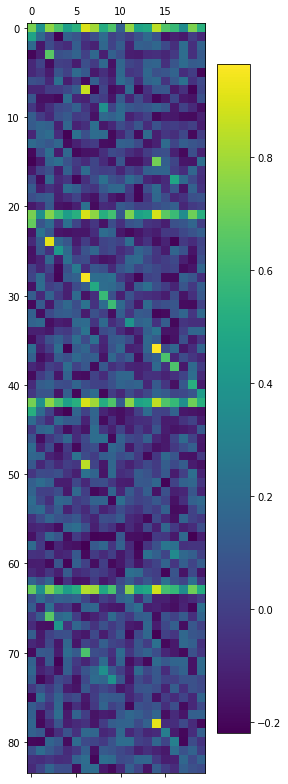

In [72]:
net_0001 = torch.load('/home/amir/data/weights_ssd/primed_0001_hint_True/ssd300_0712_5000.pth')
net_0001.keys()
w=net_0001['conf_controllers.0.weight']
w = r(w)
import seaborn as sns
matshow(w);colorbar()

In [18]:
len(net_before.keys())

106

In [4]:
net_before = torch.load('/home/amir/data/weights_ssd/baseline/ssd300_0712_5000.pth1')

In [11]:
key = 'vgg_controllers.0.weight'
key='conf_controllers.0.weight'

In [12]:
net_before[key]-net_0001[key]


-5.5860e-01 -1.8432e-01 -6.9907e-01  ...  -5.5806e-01 -7.1020e-01 -3.4965e-01
-3.4109e-01  5.5240e-03 -5.8388e-03  ...  -9.2427e-03 -7.4473e-03 -8.9303e-03
-1.1715e-03 -2.6989e-02 -1.1896e-02  ...   2.2110e-03 -1.3440e-02  5.3968e-04
                ...                   ⋱                   ...                
-6.3985e-03  4.1446e-03 -8.2526e-03  ...  -1.0570e-02  6.2853e-05 -3.2436e-03
-1.0316e-02 -5.7349e-03 -1.5672e-02  ...   4.4534e-03 -5.0147e-02  2.4683e-03
-1.1590e-02 -1.8694e-03 -5.9540e-03  ...   5.7201e-03  9.4000e-04 -8.3167e-02
[torch.cuda.FloatTensor of size 84x20 (GPU 0)]

In [4]:
%%javascript

IPython.keyboard_manager.edit_shortcuts.add_shortcut('ctrl-enter', {
    help : "run cell and keep focus", //This is optional
    handler : function (event) {
        IPython.notebook.execute_cell();
        IPython.notebook.edit_mode();
        return false;
    }}
);


<IPython.core.display.Javascript object>

In [10]:
import torch
W,H=64,64
I = torch.rand(3,W,H)
v = torch.rand(3,1)
v=v.unsqueeze(2)
I1 = I * v



(0 ,.,.) = 
  0.4093  0.1204  0.4240  ...   0.2221  0.3997  0.4161
  0.4330  0.0621  0.2761  ...   0.1486  0.1914  0.4125
  0.1971  0.4387  0.1989  ...   0.1378  0.2234  0.3766
           ...             ⋱             ...          
  0.0278  0.1689  0.1042  ...   0.3384  0.3423  0.4402
  0.2765  0.0212  0.2735  ...   0.1930  0.3162  0.1164
  0.2719  0.4563  0.0859  ...   0.4174  0.1330  0.0721

(1 ,.,.) = 
  0.3169  0.1318  0.0387  ...   0.0272  0.1838  0.0704
  0.0769  0.2653  0.3136  ...   0.2503  0.0772  0.1282
  0.0141  0.2169  0.3397  ...   0.2383  0.2382  0.0960
           ...             ⋱             ...          
  0.1377  0.2903  0.0449  ...   0.0975  0.0048  0.0213
  0.2795  0.2017  0.2126  ...   0.1310  0.2544  0.2900
  0.2587  0.0514  0.0208  ...   0.1851  0.2606  0.2063

(2 ,.,.) = 
  0.1095  0.2440  0.2512  ...   0.1162  0.1126  0.0477
  0.1732  0.2004  0.1983  ...   0.1569  0.1379  0.1175
  0.0763  0.0210  0.1606  ...   0.0208  0.0999  0.2465
           ...            

In [7]:
item[0]

NameError: name 'item' is not defined

In [13]:
type(a)

collections.OrderedDict

KeyError: 0

In [11]:
for k,v in a.():
    break

AttributeError: 'collections.OrderedDict' object has no attribute 'iteritems'

## Load Image 
### Here we just load a sample image from the VOC07 dataset 

'/home/amir/data/VOCdevkit/'

In [20]:
testset.ids

[('/home/amir/code/jacky/VOC2007', '000068'),
 ('/home/amir/code/jacky/VOC2007', '000069'),
 ('/home/amir/code/jacky/VOC2007', '000007'),
 ('/home/amir/code/jacky/VOC2007', '000070'),
 ('/home/amir/code/jacky/VOC2007', '000071'),
 ('/home/amir/code/jacky/VOC2007', '000072'),
 ('/home/amir/code/jacky/VOC2007', '000073'),
 ('/home/amir/code/jacky/VOC2007', '000074'),
 ('/home/amir/code/jacky/VOC2007', '000075'),
 ('/home/amir/code/jacky/VOC2007', '000076'),
 ('/home/amir/code/jacky/VOC2007', '000077'),
 ('/home/amir/code/jacky/VOC2007', '000078'),
 ('/home/amir/code/jacky/VOC2007', '000079'),
 ('/home/amir/code/jacky/VOC2007', '000008'),
 ('/home/amir/code/jacky/VOC2007', '000080'),
 ('/home/amir/code/jacky/VOC2007', '000009'),
 ('/home/amir/code/jacky/VOC2007', '000545'),
 ('/home/amir/code/jacky/VOC2007', '000546'),
 ('/home/amir/code/jacky/VOC2007', '000547'),
 ('/home/amir/code/jacky/VOC2007', '000548'),
 ('/home/amir/code/jacky/VOC2007', '000549'),
 ('/home/amir/code/jacky/VOC2007',

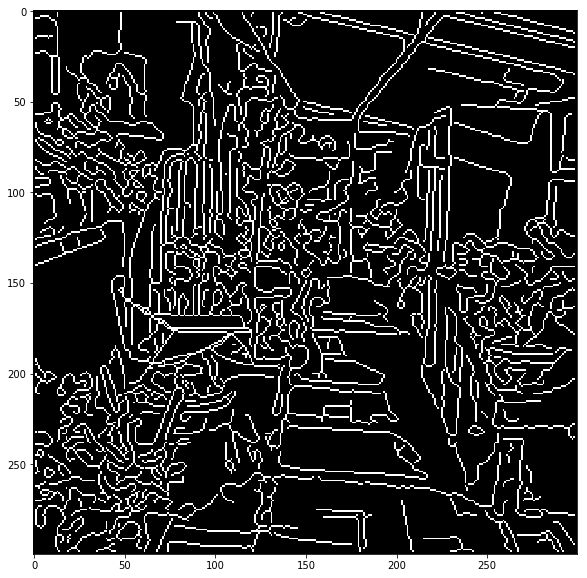

In [51]:
# image = cv2.imread('./data/example.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
from data import VOCDetection, VOCroot, AnnotationTransform
VOCroot = '/home/amir/code/jacky/'
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
testset = VOCDetection(VOCroot, [('2007', 'test')], None, AnnotationTransform)
img_id = 100


image = cv2.imread('/home/amir/code/jacky/sketch_jacky/armchair/481.jpg')
#image = testset.pull_image(img_id)
#image = 1-cv2.imread('/home/amir/data/sketch/airplane/10.png')

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

In [ ]:
cv2.imro

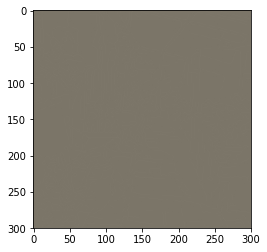

In [53]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [54]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

/home/amir/anaconda3/envs/pt3/lib/python3.5/site-packages/torch/tensor.py:309: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.mul(other)


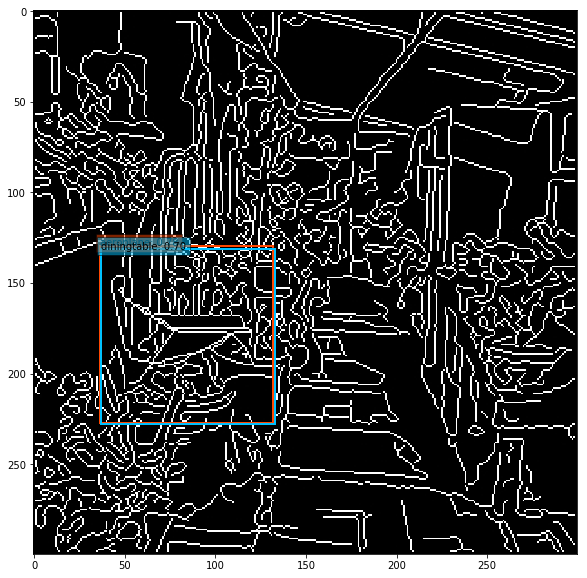

In [55]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor([rgb_image.shape[1::-1], rgb_image.shape[1::-1]])
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+s1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1